In [1]:
import xarray as xr
import numpy as np
import datetime
from datetime import date, timedelta
from t2m_utils import *
from obs_utils import *
from fcst_utils import *
from scipy.stats import bootstrap
import gc

In [ ]:
print(xr.__version__)

In [2]:
fil_rmm_erai='/scratch/stan/s2s/data/obs/rmm_ERA-Interim.nc'

In [3]:
ds_rmm=xr.open_dataset(fil_rmm_erai,decode_times=False)

In [4]:
times=ds_rmm['amplitude'].time
init_time=date(1960,1,1)+timedelta(int(times[0]))
time=[]
for i in range(len(times)):
        time.append(init_time+timedelta(i))

In [5]:
import pandas as pd
ds_rmm['time'] = pd.to_datetime(time,format="%Y/%m/%d")

ERA-Interim data covers 01/01/1979-08/31/2019, 7 years and 8 months, 14853 days

In [6]:
fil_t2m_erai='/shared/land/ERA-INTERIM/no2t/no2t_*.nc4'
ds_t2m_erai=xr.open_mfdataset(fil_t2m_erai,combine='nested', concat_dim='time', parallel=True)

* Change time variable to a continuous distribution 
* Rename lon,lat to match the forecast - useful for plotting


In [7]:
base = datetime.datetime(1979,1,1)
numdays=14853
date_list = [base + datetime.timedelta(days=x) for x in range(numdays)]
ds_t2m_erai['time']=date_list
ds_t2m_erai=ds_t2m_erai.rename({'lon': 'longitude','lat': 'latitude'})

Calculate anomalies of observations for the period of forecast 01/01/2011-21/31/2018

In [9]:
tBegin='01-01-2011'
tEnd='12-31-2018'
t2m_obs_anom=calcAnomObs(ds_t2m_erai['no2t'].sel(time=slice(tBegin,tEnd)),'t2m_anom')

Read in forecast data

In [10]:
fil_t2m_ufs_1='/project/navgem/data/ufs5/mean/t2m_*01.nc'
fil_t2m_ufs_15='/project/navgem/data/ufs5/mean/t2m_*15.nc'

In [11]:
ds_t2m_ufs_1=xr.open_mfdataset(fil_t2m_ufs_1,combine='nested',concat_dim='time',parallel=True)
ds_t2m_ufs_15=xr.open_mfdataset(fil_t2m_ufs_15,combine='nested',concat_dim='time',parallel=True)

Select all days in November-December-January-February-March

In [12]:
rmm_obs_ndjfm = ds_rmm['amplitude'].sel(time=is_ndjfm(ds_rmm['time.month']))
pha_obs_ndjfm = ds_rmm['phase'].sel(time=is_ndjfm(ds_rmm['time.month']))

Generate time limits for each initial condition 

In [13]:
nyrs=8
yrStrt=2011
mmStrt=1
initial_days=[1, 15]

dStrt=[]
for dd in initial_days:
    dStrt.append(date(yrStrt,mmStrt,dd))
dLast=[]
for i in range(len(initial_days)):
    dLast.append(dStrt[i]+timedelta(days=nyrs*366))

Select the time period of the forecast 01/01/2011-12/31/2018

In [14]:
rmm_obs_1=rmm_obs_ndjfm.sel(time=slice(dStrt[0],dLast[0]))
rmm_obs_15=rmm_obs_ndjfm.sel(time=slice(dStrt[1],dLast[1]))

pha_obs_1=pha_obs_ndjfm.sel(time=slice(dStrt[0],dLast[0]))
pha_obs_15=pha_obs_ndjfm.sel(time=slice(dStrt[1],dLast[1]))

Select initial conditions in the forecast

In [15]:
rmm_fcst_1 = rmm_obs_1.sel(time=is_day1(rmm_obs_1['time.day']))
rmm_fcst_15 = rmm_obs_15.sel(time=is_day15(rmm_obs_15['time.day']))

pha_fcst_1 = pha_obs_1.sel(time=is_day1(pha_obs_1['time.day']))
pha_fcst_15 = pha_obs_15.sel(time=is_day15(pha_obs_15['time.day']))

Select MJO events for MJO phase 3 and 7

In [16]:
phase3 = 3
mjo_events_1_p3 = select_mjo_event(rmm_fcst_1,pha_fcst_1,phase3)
mjo_events_15_p3 = select_mjo_event(rmm_fcst_15,pha_fcst_15,phase3)

phase7 = 7
mjo_events_1_p7 = select_mjo_event(rmm_fcst_1,pha_fcst_1,phase7)
mjo_events_15_p7 = select_mjo_event(rmm_fcst_15,pha_fcst_15,phase7)


Calculate phase composites of **observations** for a given week

In [36]:
week='week4'

var_name='t2m_anom_p3'
obs_comp_anoms_1_p3=calcComposites(t2m_obs_anom,mjo_events_1_p3,week,var_name)
obs_comp_anoms_15_p3=calcComposites(t2m_obs_anom,mjo_events_15_p3,week,var_name)

var_name='t2m_anom_p7'
obs_comp_anoms_1_p7=calcComposites(t2m_obs_anom,mjo_events_1_p7,week,var_name)
obs_comp_anoms_15_p7=calcComposites(t2m_obs_anom,mjo_events_15_p7,week,var_name)

In [37]:
obs_comp_anoms_p3=xr.concat([obs_comp_anoms_1_p3,obs_comp_anoms_15_p3],dim='mjo_events')
obs_comp_anoms_p7=xr.concat([obs_comp_anoms_1_p7,obs_comp_anoms_15_p7],dim='mjo_events')

Calculate statistical significance of composites (**observations**) over the MJO events

In [38]:
n_samples=1000
sig_level=0.95
obs_low_p3,obs_high_p3=test_sig(obs_comp_anoms_p3,sig_level,n_samples)
obs_low_p7,obs_high_p7=test_sig(obs_comp_anoms_p7,sig_level,n_samples)

In [39]:
obs_mask_p3=np.where((obs_low_p3.squeeze(axis=0)<0) & (obs_high_p3.squeeze(axis=0)>0),np.nan,1)
obs_mask_p7=np.where((obs_low_p7.squeeze(axis=0)<0) & (obs_high_p7.squeeze(axis=0)>0),np.nan,1)

Calculate **forecast** anomalies

In [21]:
t2m_anom_ufs_1=calcAnom(ds_t2m_ufs_1['t2m'],'t2m_anom')
t2m_anom_ufs_15=calcAnom(ds_t2m_ufs_15['t2m'],'t2m_anom')

Calculate phase composites of **forecasts** for a given week

In [32]:
week='week4'

var_name='t2m_anom_p3'
ufs_comp_anoms_1_p3=calcComposites(t2m_anom_ufs_1,mjo_events_1_p3,week,var_name)
ufs_comp_anoms_15_p3=calcComposites(t2m_anom_ufs_15,mjo_events_15_p3,week,var_name)

var_name='t2m_anom_p7'
ufs_comp_anoms_1_p7=calcComposites(t2m_anom_ufs_1,mjo_events_1_p7,week,var_name)
ufs_comp_anoms_15_p7=calcComposites(t2m_anom_ufs_15,mjo_events_15_p7,week,var_name)

Combine all MJO events in **forecast**

In [33]:
ufs_comp_anoms_p3=xr.concat([ufs_comp_anoms_1_p3,ufs_comp_anoms_15_p3],dim='mjo_events')
ufs_comp_anoms_p7=xr.concat([ufs_comp_anoms_1_p7,ufs_comp_anoms_15_p7],dim='mjo_events')

Calculate statistical significance of composites (**forecast**) over the MJO events

In [34]:
n_samples=1000
sig_level=0.95
ufs_low_p3,ufs_high_p3=test_sig(ufs_comp_anoms_p3,sig_level,n_samples)
ufs_low_p7,ufs_high_p7=test_sig(ufs_comp_anoms_p7,sig_level,n_samples)

In [35]:
ufs_mask_p3=np.where((ufs_low_p3.squeeze(axis=0)<0) & (ufs_high_p3.squeeze(axis=0)>0),np.nan,1)
ufs_mask_p7=np.where((ufs_low_p7.squeeze(axis=0)<0) & (ufs_high_p7.squeeze(axis=0)>0),np.nan,1)

Plot composites 

/homes/stan/.local/lib/python3.7/site-packages/proplot/colors.py:2281: RuntimeWarning: invalid value encountered in true_divide
  return y0 + (y1 - y0) * (x - x0) / (x1 - x0)


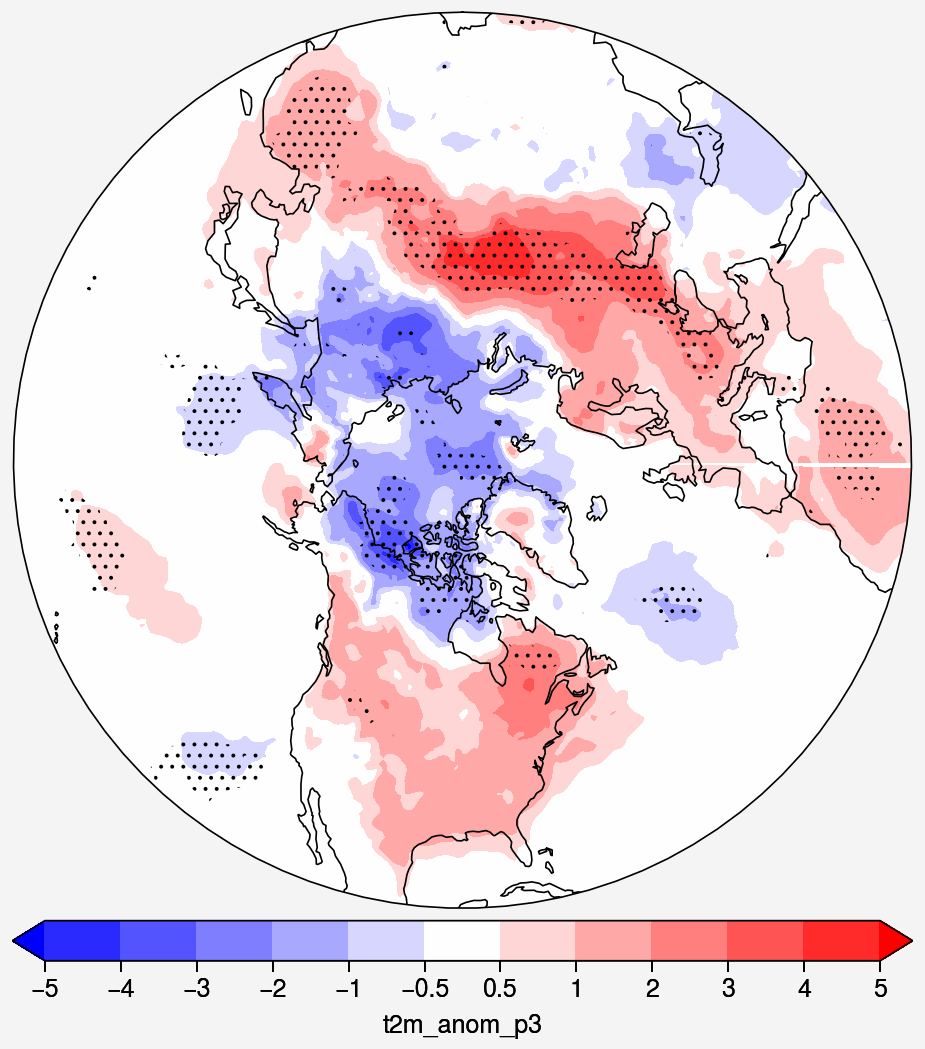

In [40]:
lon_0 = 270
lat_0 = 20
cmap='bwr'
clevs=[-5.0, -4.0, -3.0, -2.0, -1.0, -0.5, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0]

plotComposites(obs_comp_anoms_p3['t2m_anom_p3'].mean(dim='mjo_events'),
               clevs,cmap,lon_0,lat_0,obs_mask_p3)

/homes/stan/.local/lib/python3.7/site-packages/proplot/colors.py:2281: RuntimeWarning: invalid value encountered in true_divide
  return y0 + (y1 - y0) * (x - x0) / (x1 - x0)


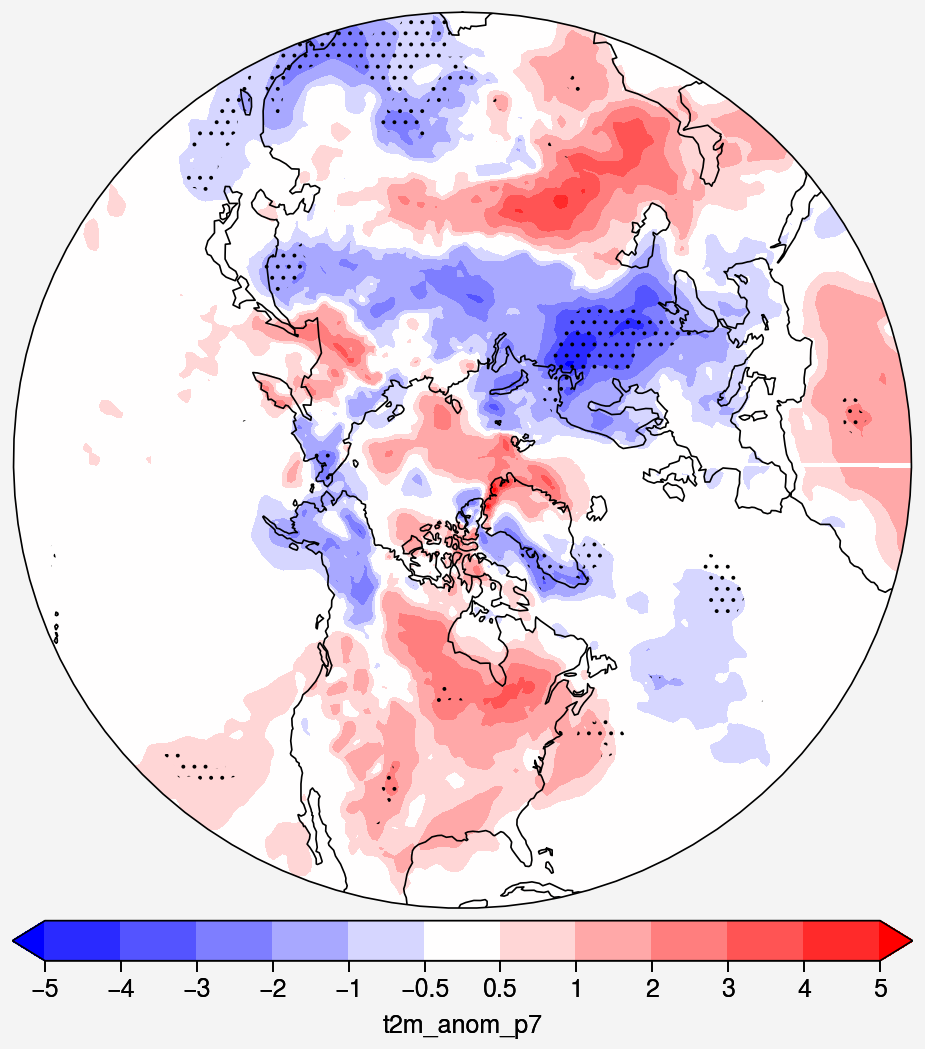

In [41]:
plotComposites(obs_comp_anoms_p7['t2m_anom_p7'].mean(dim='mjo_events'),
               clevs,cmap,lon_0,lat_0,obs_mask_p7)

/homes/stan/.local/lib/python3.7/site-packages/proplot/colors.py:2281: RuntimeWarning: invalid value encountered in true_divide
  return y0 + (y1 - y0) * (x - x0) / (x1 - x0)


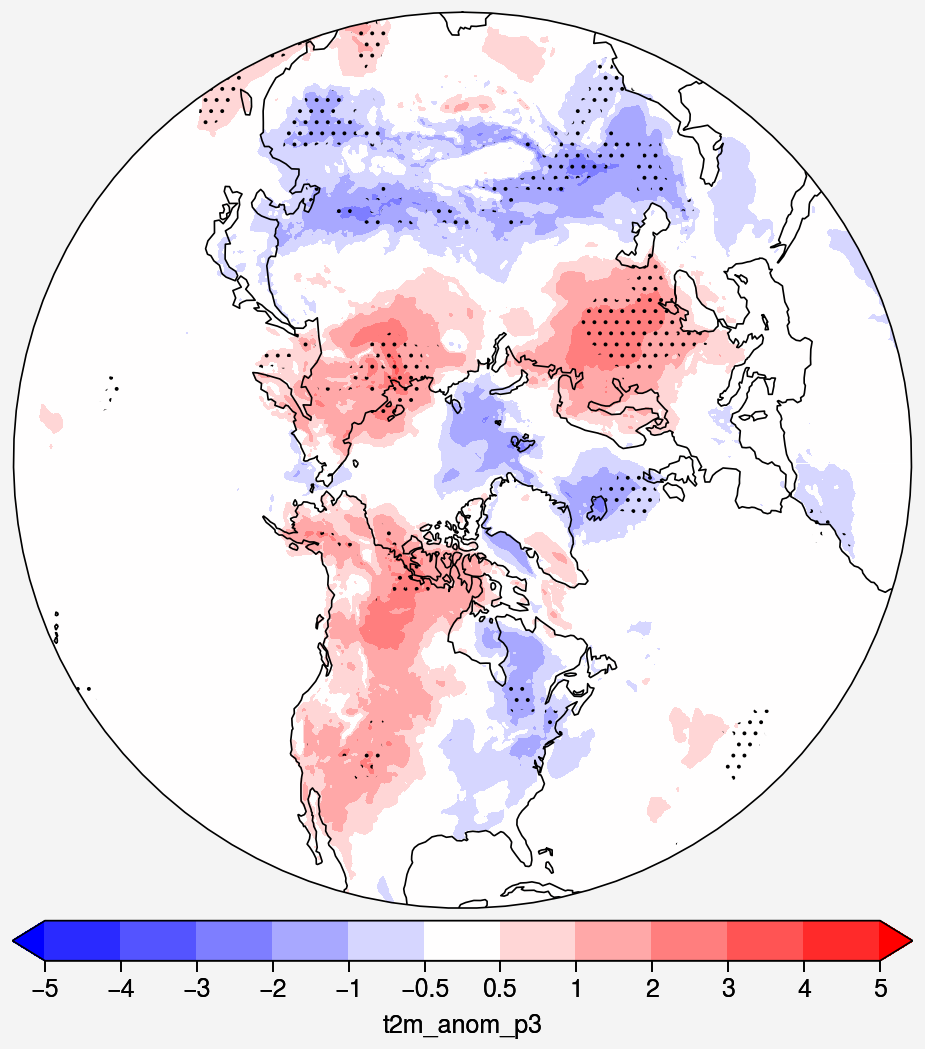

In [42]:
plotComposites(ufs_comp_anoms_p3['t2m_anom_p3'].mean(dim='mjo_events'),
               clevs,cmap,lon_0,lat_0,ufs_mask_p3)

/homes/stan/.local/lib/python3.7/site-packages/proplot/colors.py:2281: RuntimeWarning: invalid value encountered in true_divide
  return y0 + (y1 - y0) * (x - x0) / (x1 - x0)


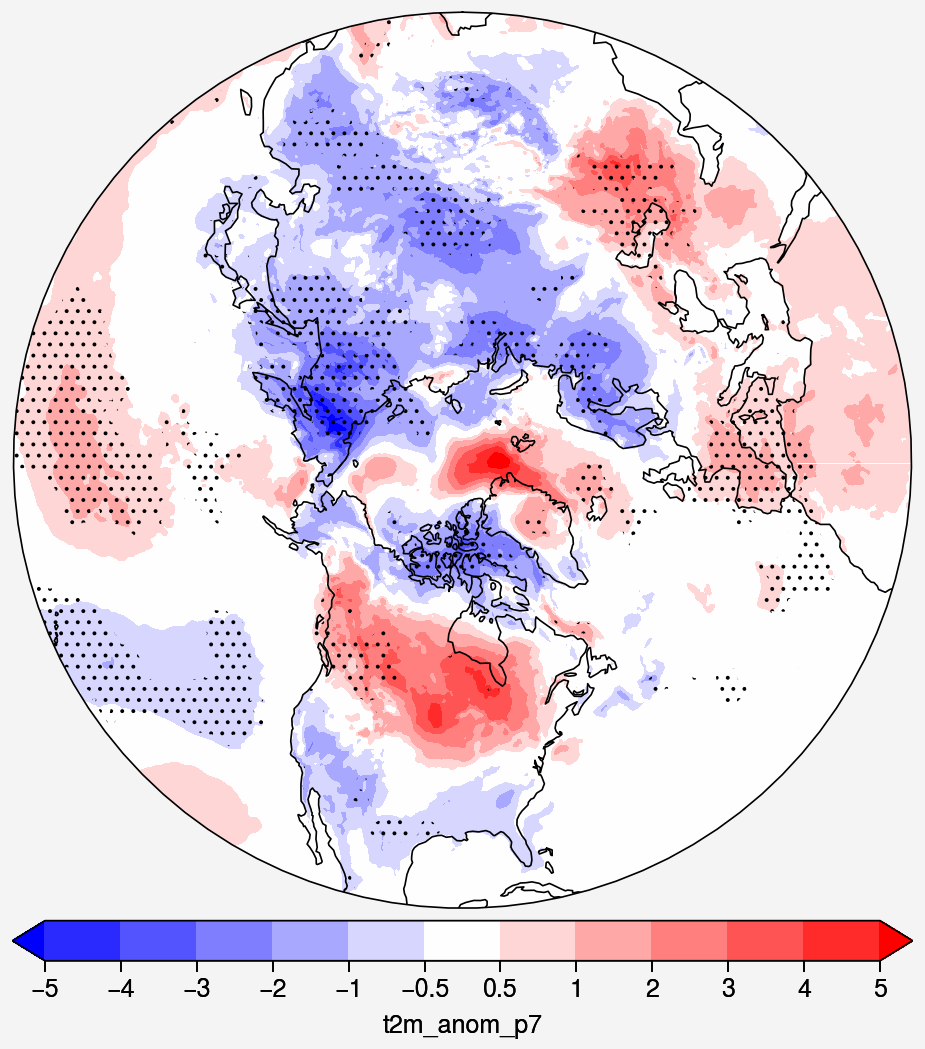

In [43]:
plotComposites(ufs_comp_anoms_p7['t2m_anom_p7'].mean(dim='mjo_events'),
               clevs,cmap,lon_0,lat_0,ufs_mask_p7)